In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [12]:
import os
dataset_dir = os.getcwd() + "/gdrive" + "/MyDrive" + "/data_upload_v3"

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
from glob import glob
import matplotlib.image as mpimg
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, BatchNormalization, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet152V2, Xception, DenseNet201
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential, load_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [14]:
covid = dataset_dir + "/covid"
normal = dataset_dir + "/nocovid"

In [15]:
count_normal = 0
count_having_covid = 0
for filename in os.listdir(covid):
    if not filename.startswith('.'):
        count_having_covid += 1
for filename in os.listdir(normal):
    if not filename.startswith('.'):
        count_normal += 1

In [ ]:
print('images labelled as covid: ', count_having_covid)
print('\nimages labelled as normal: ', count_normal)
print('\ntotal images: ', count_having_covid + count_normal)

images labelled as covid:  184

images labelled as normal:  250

total images:  434


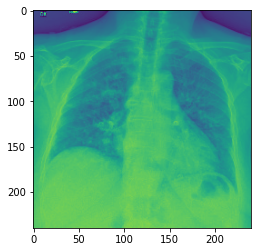

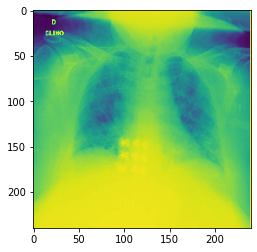

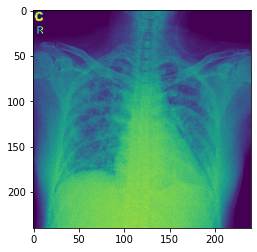

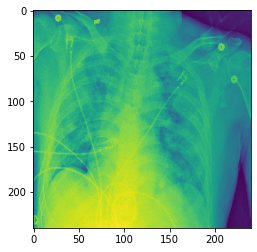

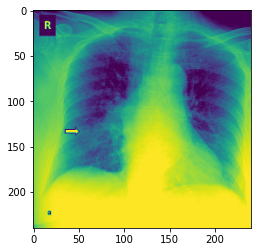

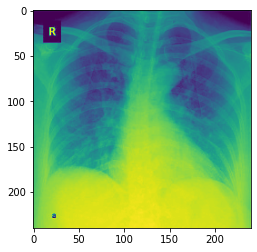

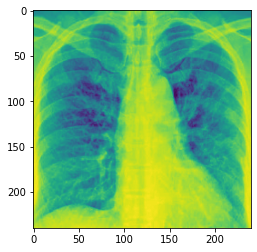

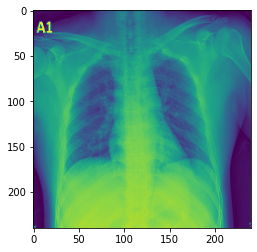

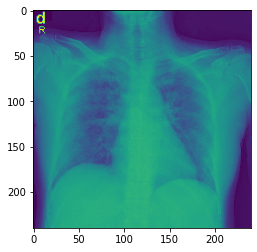

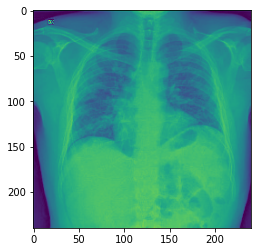

In [ ]:
def process(filename: str=None) -> None:
    image = mpimg.imread(filename)
    plt.figure()
    plt.imshow(image)

i=0

for filename in os.listdir(covid):
    if i<10:
        process(covid + '/' + filename)
        i += 1
    else:
        break

In [ ]:
# Function for Image preprocessing
def processDataset(dataset_src, dataset_dest):
    # Making a Copy of Dataset
    shutil.copytree(src, dest)
    for folder in os.listdir(dest):
        for (index, filen) in enumerate(os.listdir(os.path.join(dest, folder)), start = 1):
            filename = f'{folder}_brain-tumor_{index}.jpg';
            img_src = os.path.join(dest, folder, filen);
            img_des = os.path.join(dest, folder, filename);
            # Preprocess the Images
            img = cv2.imread(img_src, );
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC);
            cv2.imwrite(img_des ,img);
            os.remove(img_src);

src = dataset_dir
dest = os.getcwd() + "/gdrive" + "/MyDrive" + "/CovidDataset2"
processDataset(src, dest)

In [16]:
CovidDataset_dir = os.getcwd() + "/gdrive" + "/MyDrive" + "/CovidDataset2"

In [ ]:
## Function for Creating Train / Validation / Test folders (One time use Only)
 
def TrainValTestSplit(root_dir, classes_dir, val_ratio = 0.10, test_ratio = 0.10):
    main_folder = os.getcwd() + "/gdrive" + "/MyDrive" + '/Covid_Splited_Data4/';

    for cls in classes_dir:
        os.makedirs(main_folder + 'train' + cls)
        os.makedirs(main_folder + 'val' + cls)
        os.makedirs(main_folder + 'test' + cls)

        src = root_dir + cls
        
        allFileNames = os.listdir(src)
        print(allFileNames)
        np.random.seed(0)
        np.random.shuffle(allFileNames)

        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), int(len(allFileNames)* (1 - test_ratio))])

        train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
        val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
        test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

        print(cls.upper(),':')
        print('Total images: ', len(allFileNames))
        print('Training: ', len(train_FileNames))
        print('Validation: ', len(val_FileNames))
        print('Testing: ', len(test_FileNames))

        for name in train_FileNames:
            shutil.copy(name, main_folder + 'train' + cls)

        for name in val_FileNames:
            shutil.copy(name, main_folder + 'val' + cls)

        for name in test_FileNames:
            shutil.copy(name, main_folder + 'test' + cls)
        print()

root_dir = CovidDataset_dir              
classes_dir = ['/covid', '/nocovid'] 
TrainValTestSplit(root_dir, classes_dir)

['covid_brain-tumor_1.jpg', 'covid_brain-tumor_2.jpg', 'covid_brain-tumor_3.jpg', 'covid_brain-tumor_4.jpg', 'covid_brain-tumor_5.jpg', 'covid_brain-tumor_6.jpg', 'covid_brain-tumor_7.jpg', 'covid_brain-tumor_8.jpg', 'covid_brain-tumor_9.jpg', 'covid_brain-tumor_10.jpg', 'covid_brain-tumor_11.jpg', 'covid_brain-tumor_12.jpg', 'covid_brain-tumor_13.jpg', 'covid_brain-tumor_14.jpg', 'covid_brain-tumor_15.jpg', 'covid_brain-tumor_16.jpg', 'covid_brain-tumor_17.jpg', 'covid_brain-tumor_18.jpg', 'covid_brain-tumor_19.jpg', 'covid_brain-tumor_20.jpg', 'covid_brain-tumor_21.jpg', 'covid_brain-tumor_22.jpg', 'covid_brain-tumor_23.jpg', 'covid_brain-tumor_24.jpg', 'covid_brain-tumor_25.jpg', 'covid_brain-tumor_26.jpg', 'covid_brain-tumor_27.jpg', 'covid_brain-tumor_28.jpg', 'covid_brain-tumor_29.jpg', 'covid_brain-tumor_30.jpg', 'covid_brain-tumor_31.jpg', 'covid_brain-tumor_32.jpg', 'covid_brain-tumor_33.jpg', 'covid_brain-tumor_34.jpg', 'covid_brain-tumor_35.jpg', 'covid_brain-tumor_36.jpg', 

In [17]:
Covid_Splited_Data_dir =  os.getcwd() + "/gdrive" + "/MyDrive" + '/Covid_Splited_Data4/'

In [18]:
## Image Data Augmentation

train_datagen = ImageDataGenerator(rescale=1/255,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   brightness_range=[0.3,1.5],
                                   horizontal_flip=True,
                                   vertical_flip=True)

val_datagen = image.ImageDataGenerator(rescale = 1./255)

test_datagen = image.ImageDataGenerator(rescale = 1./255)

TRAIN_DIR = Covid_Splited_Data_dir + "/train"
VAL_DIR = Covid_Splited_Data_dir + "/val"
TEST_DIR = Covid_Splited_Data_dir + "/test"

In [19]:
training_set = train_datagen.flow_from_directory(TRAIN_DIR,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical',
                                                shuffle=False)

validation_set = val_datagen.flow_from_directory(VAL_DIR,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical',
                                                shuffle=False)

testing_set = test_datagen.flow_from_directory(TEST_DIR,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical',
                                              shuffle=False)

Found 347 images belonging to 2 classes.
Found 43 images belonging to 2 classes.
Found 44 images belonging to 2 classes.


In [20]:
image_size =[224, 224]

In [21]:
inception = InceptionV3(input_shape = image_size + [3], include_top = False, weights = 'imagenet')

87924736/87910968 [==============================] - 1s 0us/step


In [22]:
for layer in inception.layers:
    layer.trainable=False

In [23]:
from keras.callbacks import ModelCheckpoint

In [24]:
filepath = 'inception_best_model2.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint]

In [25]:
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D

In [26]:
x = (inception.output)
x = Flatten()(x)
prediction=Dense(2, activation='softmax')(x)

model2 = Model(inputs=inception.input, outputs=prediction)

In [27]:
model2.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(0.001),
    metrics=['accuracy']
)

In [28]:
r2 = model2.fit(
    training_set,
    validation_data=validation_set,
    epochs = 30,
    steps_per_epoch = training_set.samples//training_set.batch_size,
    validation_steps = validation_set.samples//validation_set.batch_size,
    callbacks=callbacks
)

Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 10.5078 - accuracy: 0.4125 
Epoch 1: val_accuracy improved from -inf to 0.56250, saving model to inception_best_model2.hdf5
10/10 [==============================] - 155s 15s/step - loss: 10.5078 - accuracy: 0.4125 - val_loss: 2.8842 - val_accuracy: 0.5625
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 2.2794 - accuracy: 0.5492
Epoch 2: val_accuracy did not improve from 0.56250
10/10 [==============================] - 8s 767ms/step - loss: 2.2794 - accuracy: 0.5492 - val_loss: 3.1575 - val_accuracy: 0.5000
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 2.9267 - accuracy: 0.5079
Epoch 3: val_accuracy improved from 0.56250 to 0.75000, saving model to inception_best_model2.hdf5
10/10 [==============================] - 7s 737ms/step - loss: 2.9267 - accuracy: 0.5079 - val_loss: 1.1488 - val_accuracy: 0.7500
Epoch 4/30
10/10 [==============================] - ETA: 0s - loss: 2.3492 -